In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from src.reader import Reader
from src.downloader import Downloader
from src.localreader import LocalReader, SHRINK, CROP
from src.processedreader import ProcessedReader

   val_loss  val_mean_squared_error      loss  mean_squared_error
0  0.707822                0.707822  0.718990            0.718990
1  0.726550                0.726550  0.334936            0.334936
2  1.208082                1.208082  0.240394            0.240394
3  0.652293                0.652293  0.289509            0.289509
4  0.739265                0.739265  0.089690            0.089690
5  0.694429                0.694429  0.088640            0.088640
6  0.697101                0.697101  0.262388            0.262388
7  0.855397                0.855397  0.153169            0.153169
8  0.714276                0.714276  0.046746            0.046746
9  0.922317                0.922317  0.066775            0.066775


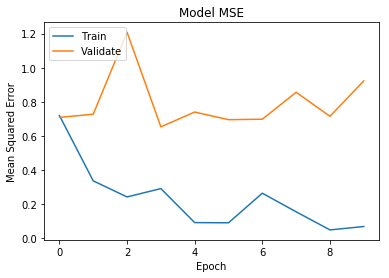

In [4]:
with open('results/trainHistoryDict', "rb") as file:
    history = pickle.load(file)
    df = pd.DataFrame.from_dict(history)
    print(df)
#     print(history.keys())
#     print(history)
    
    # Plot training & validation accuracy values
    plt.plot(history['mean_squared_error'])
    plt.plot(history['val_mean_squared_error'])
    plt.title('Model MSE')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.show()

#     # Plot training & validation loss values
#     plt.plot(history['loss'])
#     plt.plot(history['mean_squared_error'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()

In [ ]:
#Download images Starting from 1st challange to 10th challange
#In other words dowload 10 1st subsets
#downloader = Downloader(start=0, end=10)
#downloader.download(path="data/AVA.txt")

In [ ]:
# reader = LocalReader(validation_size=0.2, shaping=CROP)
# reader.preprocess(start=0, end=1)

In [ ]:
reader = LocalReader(validation_size=0.2, shaping=CROP)
for images, scores in reader.train(start=0, end=10):
    print(images.shape)
    print(scores.shape)

In [ ]:
reader = LocalReader(validation_size=0.2, shaping=SHRINK)
for images, scores in reader.train(start=0, end=10):
    print(images.shape)
    print(scores.shape)

In [ ]:
reader = LocalReader(shaping=CROP)
reader.preprocess(start=0, end=10)

In [5]:
downloader = Downloader(start=437, end=438)
downloader.download(path="data/AVA.txt")